# (4주차) 9월27일 -- draft
> 딥러닝의 기초 - 회귀분석(3)-- step 4의 다른표현 (옵티마이저)

- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈

## Imports

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

## numpy, torch (선택학습)

### numpy, torch는 엄청 비슷해요 

`-` torch.tensor() = np.array() 처럼 생각해도 무방 

In [2]:
np.array([1,2,3]), torch.tensor([1,2,3])

(array([1, 2, 3]), tensor([1, 2, 3]))

`-` 소수점의 정밀도에서 차이가 있음 (torch가 좀 더 쪼잔함) 

In [3]:
np.array([3.123456789])

array([3.12345679])

In [4]:
torch.tensor([3.123456789])

tensor([3.1235])

`-` 기본적인 numpy 문법은 np 대신에 torch를 써도 무방 // 완전 같지는 않음 

In [5]:
np.arange(10), torch.arange(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [6]:
np.linspace(0,1,10), torch.linspace(0,1,10)

(array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000]))

In [7]:
np.random.randn(10)

array([ 0.90335462,  0.44737938,  0.89509754, -0.61002167, -0.51081889,
       -1.27358181, -1.45469377,  0.2333329 , -1.98983017,  0.15708354])

In [8]:
torch.randn(10)

tensor([ 2.6161,  0.3701, -1.0635,  0.0189, -0.2754,  0.7618,  0.4842, -0.1231,
        -0.5390, -0.7580])

### length $n$ vector, $n \times 1$ col-vector, $1 \times n$ row-vector 

`-` 길이가 3인 벡터 선언방법 

In [9]:
a = torch.tensor([1,2,3])
a.shape

torch.Size([3])

`-` 3x1 col-vec 선언방법 

(방법1)

In [10]:
a = torch.tensor([[1],[2],[3]])
a.shape

torch.Size([3, 1])

(방법2)

In [11]:
a = torch.tensor([1,2,3]).reshape(3,1)
a.shape

torch.Size([3, 1])

`-` 1x3 row-vec 선언방법 

(방법1)

In [12]:
a = torch.tensor([[1,2,3]])
a.shape

torch.Size([1, 3])

(방법2)

In [13]:
a = torch.tensor([1,2,3]).reshape(1,3)
a.shape

torch.Size([1, 3])

`-` 3x1 col-vec 선언방법, 1x3 row-vec 선언방법에서 `[[1],[2],[3]]` 혹은 `[[1,2,3]]` 와 같은 표현이 이해안되면 아래링크로 가셔서 

https://guebin.github.io/STBDA2022/2022/03/14/(2주차)-3월14일.html

첫번째 동영상 12:15 - 22:45 에 해당하는 분량을 학습하시길 바랍니다. 

### torch의 dtype

`-` 기본적으로 torch는 소수점으로 저장되면 dtype=torch.float32 가 된다. (이걸로 맞추는게 편리함) 

In [14]:
tsr = torch.tensor([1.23,2.34])
tsr

tensor([1.2300, 2.3400])

In [15]:
tsr.dtype

torch.float32

`-` 정수로 선언하더라도 dtype를 torch.float32로 바꾸는게 유리함 

(안 좋은 선언예시) 

In [16]:
tsr = torch.tensor([1,2])
tsr 

tensor([1, 2])

In [17]:
tsr.dtype

torch.int64

(좋은 선언예시1) 

In [18]:
tsr = torch.tensor([1,2],dtype=torch.float32)
tsr 

tensor([1., 2.])

In [19]:
tsr.dtype

torch.float32

(좋은 선언예시2) 

In [20]:
tsr = torch.tensor([1,2.0])
tsr 

tensor([1., 2.])

In [21]:
tsr.dtype

torch.float32

(사실 int로 선언해도 나중에 float으로 바꾸면 큰 문제없음) 

In [22]:
tsr = torch.tensor([1,2]).float()
tsr

tensor([1., 2.])

In [23]:
tsr.dtype

torch.float32

`-` 왜 정수만으로 torch.tensor를 만들때에도 torch.float32로 바꾸는게 유리할까? $\to$ torch.tensor끼리의 연산에서 문제가 될 수 있음 

별 문제 없을수도 있지만 

In [24]:
torch.tensor([1,2])-torch.tensor([1.0,2.0]) 

tensor([0., 0.])

에러가 날수도 있다 

In [25]:
torch.tensor([[1.0,0.0],[0.0,1.0]]) @ torch.tensor([[1],[2]]) 

RuntimeError: expected scalar type Float but found Long

In [ ]:
torch.tensor([[1,0],[0,1]]) @ torch.tensor([[1.0],[2.0]])

둘다 정수로 통일하는것도 방법이지만 

In [26]:
torch.tensor([[1,0],[0,1]]) @ torch.tensor([[1],[2]])

tensor([[1],
        [2]])

둘다 소수로 통일하는게 더 좋음 

In [27]:
torch.tensor([[1.0,0.0],[0.0,1.0]]) @ torch.tensor([[1.0],[2.0]])

tensor([[1.],
        [2.]])

### shape of vector

`-` 행렬곱셈에 대한 shape 조심

In [28]:
A = torch.tensor([[2.00,0.00],[0.00,3.00]]) 
b1 = torch.tensor([[-1.0,-5.0]])
b2 = torch.tensor([[-1.0],[-5.0]])
b3 = torch.tensor([-1.0,-5.0])

In [29]:
A.shape,b1.shape,b2.shape,b3.shape

(torch.Size([2, 2]), torch.Size([1, 2]), torch.Size([2, 1]), torch.Size([2]))

`-` A@b1: 계산불가, b1@A: 계산가능

In [30]:
A@b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x2 and 1x2)

In [31]:
b1@A

tensor([[ -2., -15.]])

`-` A@b2: 계산가능, b2@A: 계산불가 

In [32]:
A@b2

tensor([[ -2.],
        [-15.]])

In [33]:
b2@A

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1 and 2x2)

`-` A@b3: 계산가능, b3@A: 계산가능 

In [34]:
(A@b3).shape ## b3를 마치 col-vec 처럼 해석

torch.Size([2])

In [35]:
(b3@A).shape ## b3를 마지 row-vec 처럼 해석

torch.Size([2])

`-` 브로드캐스팅 

In [36]:
a = torch.tensor([1,2,3])
a - 1

tensor([0, 1, 2])

In [37]:
b = torch.tensor([[1],[2],[3]])
b - 1

tensor([[0],
        [1],
        [2]])

In [38]:
a - b # a를 row-vec 로 해석

tensor([[ 0,  1,  2],
        [-1,  0,  1],
        [-2, -1,  0]])

## step1의 다른버전 (복습 + $\alpha$)

`-` net를 만들어서 yhat을 구할경우 step1~4를 끝까지 한번진행해보자. 

### read data 

`-` web -> df

In [39]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-09-22-regression.csv") 
df

,x,y
0,-2.482113,-8.542024
1,-2.362146,-6.576713
2,-1.997295,-5.949576
3,-1.623936,-4.479364
4,-1.479192,-4.251570
...,...,...
95,2.244400,10.325987
96,2.393501,12.266493
97,2.605604,13.098280
98,2.605658,12.546793


`-` df -> tensor

In [40]:
x= torch.tensor(df.x,dtype=torch.float32).reshape(100,1)
y= torch.tensor(df.y,dtype=torch.float32).reshape(100,1)
X= torch.tensor([[1]*100,x]).T

### ver1: net = torch.nn.Linear(1,1,bias=True) 

`-` step1: yhat

In [41]:
net = torch.nn.Linear(in_features=1,out_features=1)
net.weight.data, net.bias.data

(tensor([[-0.2735]]), tensor([0.7507]))

In [42]:
net.weight.data = torch.tensor([[10.0]])
net.bias.data = torch.tensor([-5.0])                         
net.weight.data, net.bias.data

(tensor([[10.]]), tensor([-5.]))

In [43]:
yhat = net(x)

`-` step2: loss 

In [44]:
loss = torch.mean((y-yhat)**2)
loss 

tensor(85.8769, grad_fn=<MeanBackward0>)

`-` step3: 미분 

(미분전상황)

In [45]:
net.weight, net.bias

(Parameter containing:
 tensor([[10.]], requires_grad=True),
 Parameter containing:
 tensor([-5.], requires_grad=True))

In [46]:
net.weight.grad, net.bias.grad

(None, None)

(미분)

In [47]:
loss.backward()  

(미분후상황)

In [48]:
net.weight, net.bias

(Parameter containing:
 tensor([[10.]], requires_grad=True),
 Parameter containing:
 tensor([-5.], requires_grad=True))

In [49]:
net.weight.grad, net.bias.grad

(tensor([[11.8893]]), tensor([-13.4225]))

`-` step4: update 

In [50]:
net.weight.data = net.weight.data - 1/10 * net.weight.grad 
net.bias.data = net.bias.data - 1/10 * net.bias.grad

In [51]:
net.weight.data,net.bias.data

(tensor([[8.8111]]), tensor([-3.6577]))

`-` 반복 

(code before)

In [52]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=True) 

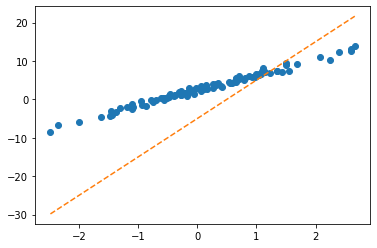

In [53]:
plt.plot(x,y,'o')
plt.plot(x,(X@What).data,'--')

In [54]:
for epoc in range(30):
    ## step1 
    yhat = X@What     
    ## step2
    loss = torch.mean((y-yhat)**2) 
    ## step3 
    loss.backward()
    ## step4 
    What.data = What.data - 1/10 * What.grad 
    What.grad = None

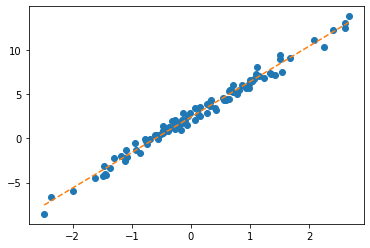

In [55]:
plt.plot(x,y,'o')
plt.plot(x,(X@What).data,'--')

(code after) 

In [56]:
net = torch.nn.Linear(in_features=1,out_features=1)
net.weight.data = torch.tensor([[10.0]])
net.bias.data = torch.tensor([-5.0]) 

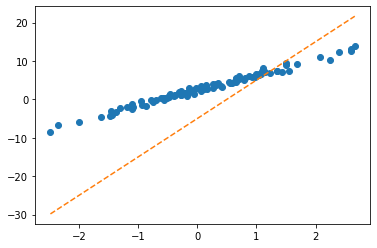

In [57]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--')

In [58]:
for epoc in range(30):
    ## step1 
    yhat = net(x)
    ## step2
    loss = torch.mean((y-yhat)**2) 
    ## step3 
    loss.backward()
    ## step4 (이게 엄청 귀찮아지네??) 
    net.weight.data = net.weight.data - 1/10 * net.weight.grad 
    net.bias.data = net.bias.data - 1/10 * net.bias.grad
    net.weight.grad = None 
    net.bias.grad = None 

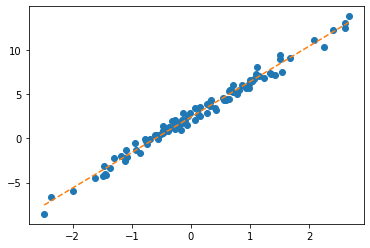

In [59]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--')

### ver2: net = torch.nn.Linear(2,1,bias=False) 

`-` step1: yhat

In [60]:
net = torch.nn.Linear(in_features=2,out_features=1,bias=False) 

In [61]:
net.weight

Parameter containing:
tensor([[-0.0199, -0.5255]], requires_grad=True)

In [62]:
net.weight.data = torch.tensor([[-5.0, 10.0]])
net.weight

Parameter containing:
tensor([[-5., 10.]], requires_grad=True)

In [63]:
yhat=net(X)

`-` step2: loss

In [64]:
loss = torch.mean((y-yhat)**2)
loss

tensor(85.8769, grad_fn=<MeanBackward0>)

`-` step3: 미분 

(미분전상황) 

In [65]:
net.weight.data

tensor([[-5., 10.]])

In [66]:
net.weight.grad

(미분) 

In [67]:
loss.backward()

(미분후상황) 

In [68]:
net.weight.data

tensor([[-5., 10.]])

In [69]:
net.weight.grad

tensor([[-13.4225,  11.8893]])

`-` step4: update 

In [70]:
net.weight.data = net.weight.data - 1/10 * net.weight.grad 
net.weight.data

tensor([[-3.6577,  8.8111]])

`-` 반복 

(code before) -- ver1과 같으므로 생략할게요

(code after)

In [71]:
net = torch.nn.Linear(in_features=2,out_features=1,bias=False)
net.weight.data = torch.tensor([[-5.0, 10.0]]) 

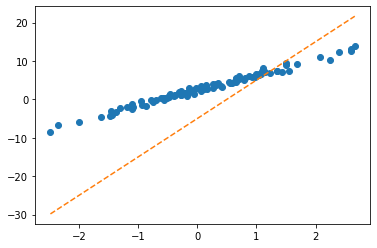

In [72]:
plt.plot(x,y,'o')
plt.plot(x,net(X).data,'--')

In [73]:
for epoc in range(30): 
    ## step1 
    yhat = net(X) 
    ## step2 
    loss = torch.mean((y-yhat)**2)
    ## step3 
    loss.backward() 
    ## step4 
    net.weight.data = net.weight.data - 1/10 * net.weight.grad
    net.weight.grad = None 

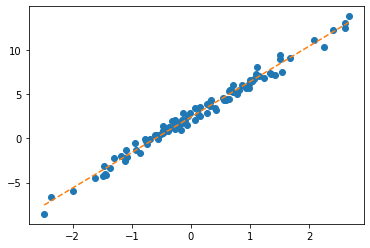

In [74]:
plt.plot(x,y,'o')
plt.plot(x,net(X).data,'--') 

## step4의 다른버전: 옵티마이저!

### ver1: net = torch.nn.Linear(1,1,bias=True) 

`-` 준비 

In [267]:
net = torch.nn.Linear(1,1) 
net.weight.data = torch.tensor([[10.0]]) 
net.bias.data = torch.tensor([[-5.0]]) 

In [268]:
optimizr = torch.optim.SGD(net.parameters(),lr=1/10) 

`-` step1~3

In [269]:
yhat = net(x)     

In [270]:
loss = torch.mean((y-yhat)**2) 

In [271]:
loss.backward() 

`-` step4 

(update 전)

In [272]:
net.weight.data, net.bias.data ## 값은 업데이트 전

(tensor([[10.]]), tensor([[-5.]]))

In [273]:
net.weight.grad, net.bias.grad ## 미분값은 청소전 

(tensor([[11.8893]]), tensor([[-13.4225]]))

(update) 

In [274]:
optimizr.step() 
optimizr.zero_grad() 

(update 후) 

In [275]:
net.weight.data, net.bias.data ## 값은 업데이트 되었음 

(tensor([[8.8111]]), tensor([[-3.6577]]))

In [276]:
net.weight.grad, net.bias.grad ## 미분값은 0으로 초기화하였음 

(tensor([[0.]]), tensor([[0.]]))

`-` 반복 

In [277]:
net = torch.nn.Linear(1,1) 
net.weight.data = torch.tensor([[10.0]])
net.bias.data = torch.tensor([-5.0])
optimizr = torch.optim.SGD(net.parameters(),lr=1/10) 

In [278]:
for epoc in range(30): 
    yhat = net(x)
    loss = torch.mean((y-yhat)**2) 
    loss.backward() 
    optimizr.step(); optimizr.zero_grad() 

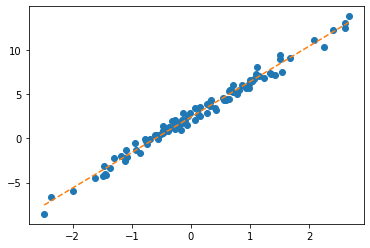

In [279]:
plt.plot(x,y,'o')
plt.plot(x,net(x).data,'--')

### ver2: net = torch.nn.Linear(2,1,bias=False) 

`-` 바로 반복하겠습니다.. 

In [231]:
net = torch.nn.Linear(2,1,bias=False) 
net.weight.data = torch.tensor([[-5.0, 10.0]])
optimizr = torch.optim.SGD(net.parameters(),lr=1/10) 

In [232]:
for epoc in range(30): 
    yhat = net(X)
    loss = torch.mean((y-yhat)**2) 
    loss.backward() 
    optimizr.step(); optimizr.zero_grad() 

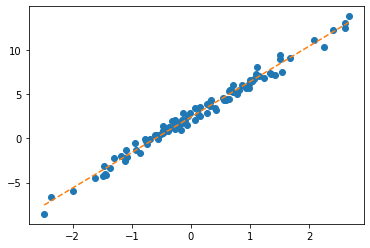

In [233]:
plt.plot(x,y,'o')
plt.plot(x,net(X).data,'--')

--- 

## Appendix: `net.parameters()`의 의미? (선택학습)

`-` iterator, generator의 개념필요 
- https://guebin.github.io/IP2022/2022/06/06/(14주차)-6월6일.html, 클래스공부 8단계 참고 


`-` 탐구시작: 네트워크 생성 

In [313]:
net = torch.nn.Linear(in_features=1,out_features=1)
net.weight

Parameter containing:
tensor([[0.1341]], requires_grad=True)

In [314]:
net.bias

Parameter containing:
tensor([-0.5970], requires_grad=True)

`-` torch.optim.SGD? 를 확인하면 params에 대한설명에 아래와 같이 되어있음 

```
params (iterable): iterable of parameters to optimize or dicts defining
        parameter groups
```

`-` 설명을 읽어보면 params에 iterable object를 넣으라고 되어있음 (iterable object는 숨겨진 명령어로 `__iter__`를 가지고 있는 오브젝트를 의미)

In [302]:
set(dir(net.parameters)) & {'__iter__'}

set()

In [303]:
set(dir(net.parameters())) & {'__iter__'}

{'__iter__'}

`-` 무슨의미? 

In [315]:
_generator = net.parameters()

In [316]:
_generator.__next__()

Parameter containing:
tensor([[0.1341]], requires_grad=True)

In [317]:
_generator.__next__()

Parameter containing:
tensor([-0.5970], requires_grad=True)

In [318]:
_generator.__next__()

StopIteration: 

`-` 이건 이런느낌인데? 

In [323]:
_generator2 = iter([net.weight,net.bias])

In [324]:
_generator2

In [325]:
_generator2.__next__()

Parameter containing:
tensor([[0.1341]], requires_grad=True)

In [326]:
_generator2.__next__()

Parameter containing:
tensor([-0.5970], requires_grad=True)

In [327]:
_generator2.__next__()

StopIteration: 

`-` 즉 아래는 같은코드이다. 

```python
### 코드1
_generator = net.parameters() 
torch.optim.SGD(_generator,lr=1/10) 
### 코드2
_generator = iter([net.weight,net.bias])
torch.optim.SGD(_generator,lr=1/10) 
### 코드3 (이렇게 써도 코드2가 실행된다고 이해할 수 있음)
_iterator = [net.weight,net.bias]
torch.optim.SGD(_iterator,lr=1/10) 
```

결론: `net.parameters()`는 net오브젝트에서 학습할 파라메터를 모두 모아 리스트(iterable object)로 만드는 함수라 이해할 수 있다. 

`-` 응용예제1

In [355]:
What = torch.tensor([[-5.0],[10.0]],requires_grad=True)
optimizr = torch.optim.SGD([What],lr=1/10) 

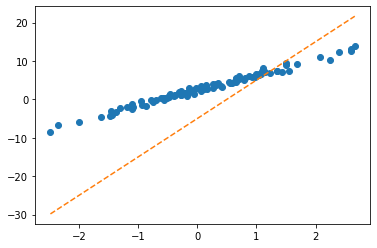

In [356]:
plt.plot(x,y,'o')
plt.plot(x,(X@What).data,'--')

In [357]:
for epoc in range(30):
    yhat = X@What 
    loss = torch.mean((y-yhat)**2)
    loss.backward()
    optimizr.step();optimizr.zero_grad() 

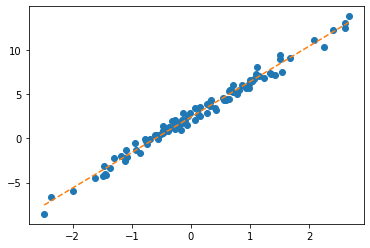

In [358]:
plt.plot(x,y,'o')
plt.plot(x,(X@What).data,'--')

`-` 응용예제2

In [359]:
b = torch.tensor(-5.0,requires_grad=True)
w = torch.tensor(10.0,requires_grad=True)
optimizr = torch.optim.SGD([b,w],lr=1/10)

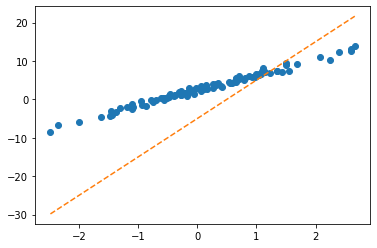

In [360]:
plt.plot(x,y,'o')
plt.plot(x,(w*x+b).data,'--')

In [361]:
for epoc in range(30):
    yhat = b+ w*x 
    loss = torch.mean((y-yhat)**2)
    loss.backward()
    optimizr.step(); optimizr.zero_grad()

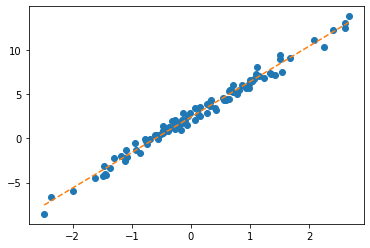

In [362]:
plt.plot(x,y,'o')
plt.plot(x,(w*x+b).data,'--')